In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# load data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
# assign Sentiment and reviews column 
reviews = df_train['Phrase']
sentiment = df_train['Sentiment']

([<matplotlib.axis.XTick at 0x7fbcb9779fd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

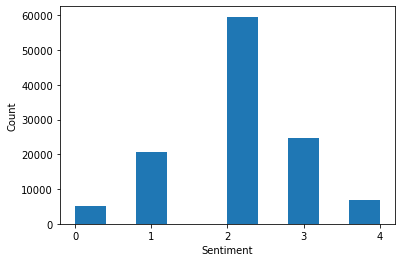

In [4]:
# visualize sentiment data
fig = plt.figure()
axes1 = fig.add_subplot(1, 1, 1)
axes1.hist(sentiment)
axes1.set_xlabel('Sentiment')
axes1.set_ylabel('Count')
plt.xticks(range(5))
# Most of the review is "neutral", what prediction i can make base on this data? 
# Maybe it shows that the data is unbalance so we cannot evaluate the model base on accuracy?
# or most of words in the phrase represent for the neutral sentiment?

In [5]:
# Count words in the review
vocab = Counter()
for phrase in reviews:
    for word in phrase.split():
        vocab[word] += 1

# Quick look at the most common word
vocab.most_common()

# There is some strange word like: -RRB-, what does it mean?
# No result from google, must find the context where this word is in.
# Luckily, it's in the second phrase of the dataset
reviews.loc[1]
# Combine with the result on google it's the LEFT ROUND BRACKET and RIGHT ROUND BRACKET, should get rid of them
# There're also digit character in the data, not much information from this digit, get rid of them.

"disguise the slack complacency of -LRB- Godard 's -RRB- vision"

In [6]:
# Function to remove -LRB- or -RRB-
def remove_brackets(text):
    for word in text.split():
        if word == '-LRB-' or word == '-RRB-':
            text = text.replace(word, '')
    return text

In [7]:
# Remove -LRB- or -RRB- in reviews
reviews = reviews.apply(remove_brackets)

In [8]:
# Function to remove special character and digits (reuse from Quaan's code)
import re
def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove any non-word character and append the emoticons,
    # Also Convert to lower case
#     text = (re.sub('[0-9]', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', ''))
    
    return text

In [9]:
# Remove special character and digits
# reviews = reviews.apply(preprocessor)

In [10]:
# download list of stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [11]:
# Remove stopwords
def remove_stopwords(text):
    filtered_word = []
    for word in text.split(' '):
        if word not in stop_words:
            filtered_word.append(word)
    return ' '.join(filtered_word)

In [12]:
# Remove stopwords before tokenizer to avoid warning while stemming
reviews = reviews.apply(remove_stopwords)

In [13]:
# Function for stemming (reuse Quan's code)
from nltk.stem import PorterStemmer

porter = PorterStemmer()

# Split a text into list of words and apply stemming technic
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [14]:
# Train Logistic Regression using tfidf
X_train = reviews
y_train = sentiment

In [15]:
# Transforms data into matrix
tfidf = TfidfVectorizer(tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
# instantiate estimator
clf = Pipeline([('vect', tfidf),
                ('clf', LogisticRegression(max_iter=10000))])

# training model
clf.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(preprocessor=<function preprocessor at 0x7fbcb7b518c0>,
                                 tokenizer=<function tokenizer_porter at 0x7fbcb7b51050>)),
                ('clf', LogisticRegression(max_iter=10000))])

In [16]:
# Evaluation on training set
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Now apply those above metrics to evaluate your model
# Your code here
predictions = clf.predict(X_train)
print('accuracy:',accuracy_score(y_train,predictions))
print('confusion matrix:\n',confusion_matrix(y_train,predictions))
print('classification report:\n',classification_report(y_train,predictions))

accuracy: 0.6754496133965568
confusion matrix:
 [[ 1270  2457  1372   143    11]
 [  406  9262  9997   854    44]
 [  147  2696 53234  3392   136]
 [   31   562 10310 13139   736]
 [    6    71  1041  3575  2153]]
classification report:
               precision    recall  f1-score   support

           0       0.68      0.24      0.36      5253
           1       0.62      0.45      0.52     20563
           2       0.70      0.89      0.79     59605
           3       0.62      0.53      0.57     24778
           4       0.70      0.31      0.43      6846

    accuracy                           0.68    117045
   macro avg       0.66      0.49      0.53    117045
weighted avg       0.67      0.68      0.65    117045



In [19]:
# Preprocessing test data
X_test = df_test['Phrase']
X_test = X_test.apply(remove_brackets)
X_test = X_test.apply(remove_stopwords)

In [20]:
# Prediction on test_set
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Now apply those above metrics to evaluate your model
# Your code here
predictions = clf.predict(X_test)
predictions

array([1, 2, 2, ..., 2, 2, 3])

In [21]:
# add result in test_set
df_test['Sentiment'] = predictions

In [22]:
# export to csv
df_test.to_csv('submission.csv')

In [ ]:
preds = clf.predict_proba(X_test)

for i in range(len(X_test)):
    print(f'{X_test[i]} --> 0, 1, 2, 3, 4, 5 = {preds[i]}')